Grupo 6: Enrique Ramos, Guillermo Mármol, Diego Forteza y Ignacio Regidor

#Preparación del entorno
Instalamos las librerías necesarias

In [ ]:
!pip install deap
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scoop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 615 kB 4.8 MB/s 
  Created wheel for scoop: filename=scoop-0.7.2.0-py3-none-any.whl size=78119 sha256=9685611866e07b70e37b0d2016841e35f661daddf6c75557e0cc62e701af953f
  Stored in directory: /root/.cache/pip/wheels/06/d1/b8/b4495d80f3aa67a67b8d19a900892d4f6af3c6d1bdd3cd015c
Successfully built scoop


##Librerías
Importamos las librerías que serán necesarias para la visualización y resolución del problema.

In [ ]:
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import matplotlib.pyplot as plt
import random


##Funciones
Definimos la función que usaremos para graficar las estadísticas de los individuos en cada generación. Se entenderá más adelante.

In [ ]:
def plot_evolucion(log, name):
    """
    Representa la evolución de la calidad o adaptación (fitness) en las 
    distintas generaciones del mejor individuo (el cual sus cromosomas (x,y) 
    obtienen un mayor valor en la función objetivo, al ser este un problema de 
    maximización), el peor individuo (el menor valor en la función objetivo) y 
    el promedio de adaptación de cada generación.
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    # ax1.fill_between(gen, fit_mins, fit_maxs, where=fit_maxs >= fit_mins, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.set_ylim([-20, 20])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.title(name)

#Resolución

##Introducción al problema
En esta práctica se nos pide encontrar los máximos de la siguiente función utilizando cruce con un punto, cruce con dos y cruce uniforme.

$f\left(x,y\right)= 3{\left(1-x\right)}^2 e^{-\left(x^2 \right)-{\left(y+1\right)}^2 } -10\left(\frac{x}{5}-x^3 -y^5 \right)e^{-x^2 -y^2 } -\frac{1}{3}e^{-{\left(x+1\right)}^2 -y^2 }$

Para el dominio:

$\left\lbrace x,y\right\rbrace \in \left\lbrack -100,100\right\rbrack$

Para ayudarnos a resolverlo usaremos una cadena de cromosomas formada por un par de genes 

$$[x_i, y_i]$$ con $$i = 1, 2, ... , n$$
En este caso serán n = 32 individuos.

Además debemos saber que la población no cambiará de una generación a otra, por tanto, será una constante. Además, la población original se elegirá de forma aleatoria usando **random.uniform** que genera números aleatorios de distribución uniforme. Realizaremos todos los algoritmos 20 veces con 20 poblaciones iniciales diferentes, la misma para las tres cada vez, para así sacar un resultado más representativo y poder valorar cual de todos los métodos de cruce funciona mejor para este problema.

##Función objetivo
Lo primero es definir la función que queremos maximizar. Para ello usamos la librería `math`. Además, para prevenir que alguno de los valores se escape del rango definido, aplicaremos la pena de muerte. Esto simplemente es reasignar cualquier valor fuera de rango a -1 para que así este individuo no participe en las operaciones de cruce y mutación.


In [ ]:
def funcion_objetivo(x):
    """
    Función objetivo de nuestro problema
    Los cromosomas entran en el vector "x"
     x[0] hace referencia al cromosoma x
     x[1] hace referencia al cromosoma y
    Devuelve -1 si los cromosomas se salen del rango [-100 , 100] (pena de muerte)
    Si no, sustituye en la función f(x,y) y devuelve el valor
    """
    for i in range(len(x)):
        if x[i] > 100 or x[i] < -100:
            return -1,
    aux = 3*math.pow(1-x[0],2)*math.exp(-math.pow(x[0],2)-math.pow(x[1]+1,2))
    aux2 = 10*(x[0]/5-math.pow(x[0],3)-math.pow(x[1],5))*math.exp(-math.pow(x[0],2)-math.pow(x[1],2))
    aux3 = math.exp(-math.pow(x[0]+1,2)-math.pow(x[1],2))/3
    res = aux-aux2-aux3
    return res,

###Análisis de la función
Ahora analicemos la función. Para ello la dibujaremos haciendo uso de la librería `mpl_toolkits.mplot3d`. Primero definimos el dominio con dos vectores de 1000 puntos igualmente espaciados entre -100 y 100. Calculamos f(x,y) para estos valores y finalmente los representamos.

Text(0.5, 0, 'f(x,y)')

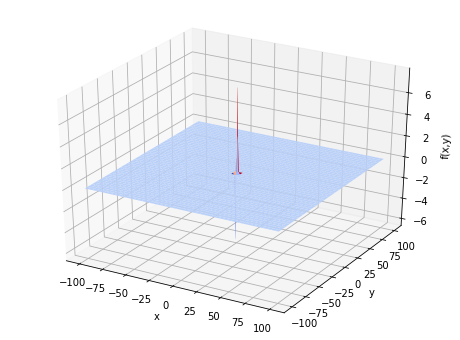

In [ ]:
# Generamos vectores que barran todo el dominio
x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)
# Evaluamos todos los valores de las variables
x_ax, y_ax = np.meshgrid(x, y)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([funcion_objetivo(val) for val in vals],(1000, 1000))
# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(8,6))
ax = figure_3d.gca(projection="3d")
ax.plot_surface(x_ax, y_ax, fx, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")

Parece que la función es igual a 0 en todos los puntos salvo se acerca a cero en ambos valores. No obstante, estudiemos la función con los algoritmos genéticos.

##Preparación de estructuras, herramientas...


###Creator
Para ello primero definimos una _estructura_ o _método_ llamado `FitnessMax`. Esta hereda de base `base.Fitness` y tiene un atributo `weights` que define el tipo de problema de optimización. Como en este caso es de maximizar `weights=(1.0,)` (el uno positivo).
Además, también nos creamos como va a ser nuestro individuo. A este _método_ le llamamos `Individual`, el cual hereda una lista, que será un par de genes como hemos dicho anteriormente, y contiene el atributo de fitness (su calidad), inicializado con el objeto `FitnessMax` (creado anteriormente).

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

###Toolbox
A continuación nos definimos nuestra *caja de herramientas* donde almacenaremos las funciones necesarias para el algoritmo. Estas son:
* Attr_Uniform: genera un valor aleatorio entre -100 y 100 haciendo uso de la libreria `random` y su método _uniform_ (distribución uniformw)
* Individual: función para **crear los individuos** de forma **aleatoria**. Esta llama a `tools.InitRepeat` la cual almacenará en un container de estructura `creator.Individual` (creada anteriormente con _creator_ ) llamando a la función `toolbox.attr_uniform` dos veces (generamos dos genes aleatorios x e y por individuo).
* Population: función para **crear la población**. Es análoga a la anterior. Lo único que esta almacena en una lista llamando a `toolbos.Individual` 32 veces. Es decir, genera 32 individuos.
* Evaluate: Función **objetivo**
* **Operadores genéticos** (selección por torneo de tres individuos, tres tipos de cruce y mutación gaussiana)

Las tres toolbox son iguales salvo en este último punto. La primera tiene un cruce `cxOnePoint` esta es un cruce de un único punto.  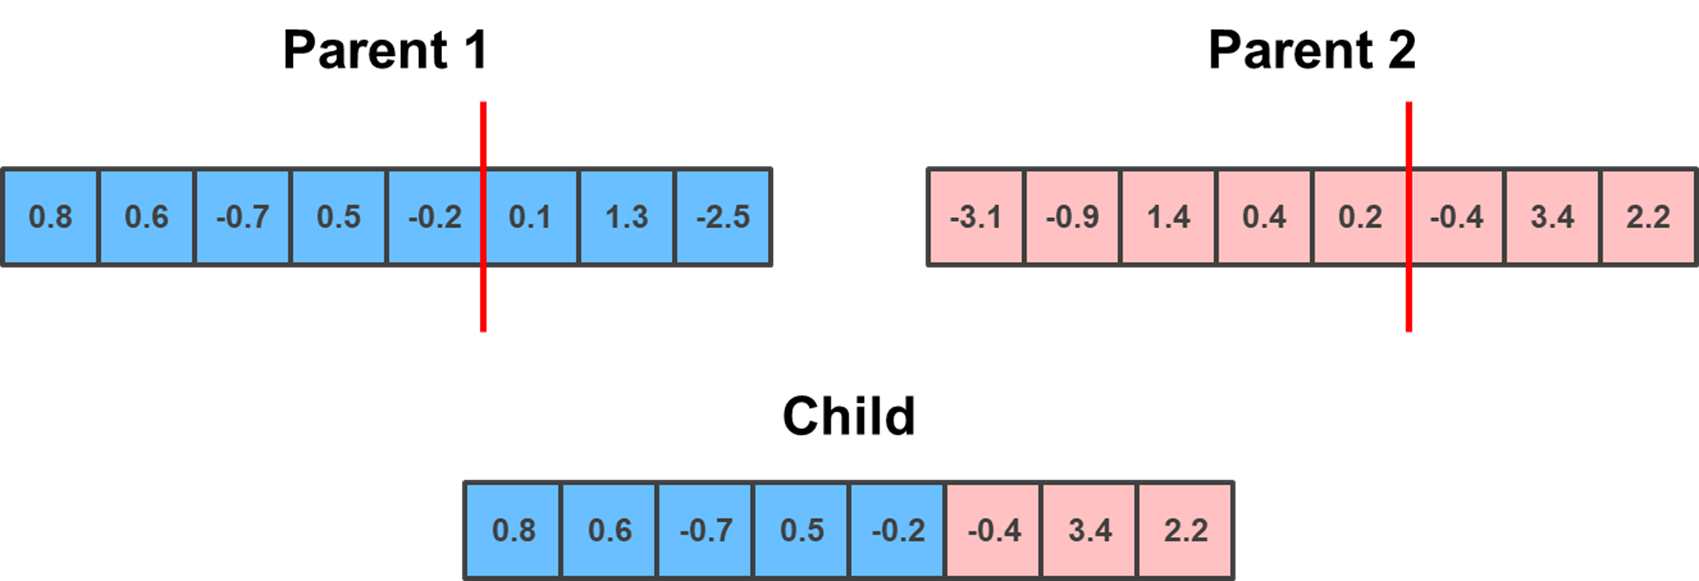

La segunda toolbox tiene un cruce `cxTwoPoint`. Esto es un cruce con dos puntos.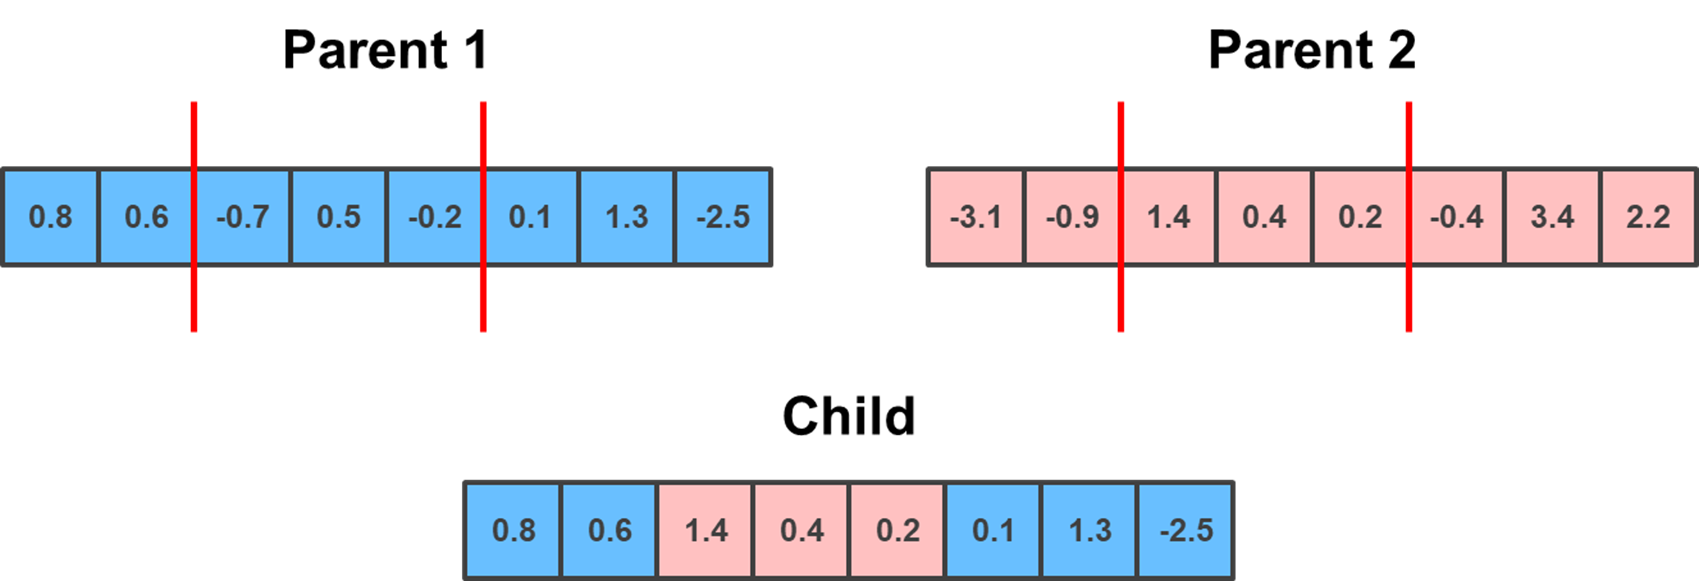

Por último, la tercera toolbox tiene el cruce `cxUniform`. Este es como lanzar una moneda al aire por cada _cromosoma_ para ver cual de los dos padres se coge. Es por eso que tenemos un nuevo atributo `indpb` el cual representa la probabilidad de intercambiar los genes. Nosotros, siguiendo la analogía de la moneda, hemos escogido una probabilidad de 0.5.
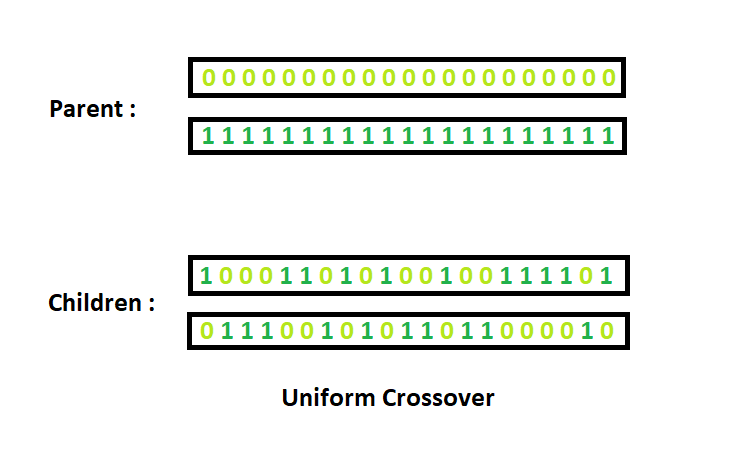  
A continuación encontramos la creación de las tres toolbox por bloques:

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_uniform", random.uniform, -100, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, 2)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, 32)
toolbox.register("evaluate", funcion_objetivo)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 5, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
toolbox2 = base.Toolbox()
toolbox2.register("attr_uniform", random.uniform, -100, 100)
toolbox2.register("individual", tools.initRepeat, creator.Individual,
                 toolbox2.attr_uniform, 2)
toolbox2.register("population", tools.initRepeat, list,
                 toolbox2.individual, 32)
toolbox2.register("evaluate", funcion_objetivo)
toolbox2.register("mate", tools.cxTwoPoint)
toolbox2.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 5, indpb=0.1)
toolbox2.register("select", tools.selTournament, tournsize=3)

In [ ]:
toolbox3 = base.Toolbox()
toolbox3.register("attr_uniform", random.uniform, -100, 100)
toolbox3.register("individual", tools.initRepeat, creator.Individual,
                 toolbox3.attr_uniform, 2)
toolbox3.register("population", tools.initRepeat, list,
                 toolbox3.individual, 32)
toolbox3.register("evaluate", funcion_objetivo)
toolbox3.register("mate", tools.cxUniform, indpb=0.5)
toolbox3.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 5, indpb=0.1)
toolbox3.register("select", tools.selTournament, tournsize=3)

###Funciones de Algoritmos Genéticos
A continuacion configuramos los AG uno a uno. Explicaremos uno ya que los otros dos serán análogos pero llamando a su respectiva toolbox (en función del tipo de cruce). Se define la probabilidad de cruce y mutacion y el numero de generaciones. 

Llamamos a la clase HallOfFame que es la manera que implementa `deap` para conservar al mejor individuo a lo largo de la evolución del algoritmo. 

Posteriormente definimos un objeto para generar estaditicas que nos ayudaran a ver como evoluciona nuestro AG. Nos interesa recoger las siguientes 4 estadisticas:

* `avg`: Desempeño medio de la población
    * Se incrementa a lo largo de las generaciones. **Positivo** porque los **individuos** que forman la población son, en media, **mejores**
* `std`: Desviación típica del desempeño medio de la población
    * Disminuye, en general, a lo largo de las generaciones. **Positivo** porque los **individuos** que forman la población son, **cada vez más parecidos** y que el algoritmo es **elitista** por el proceso de selección
* `min`: Mínimo desempeño de la población
* `max`: Máximo desempeño de la población
    * Aumenta a lo largo de las generaciones. **Muy positivo** porque indica que el algoritmo funciona correctamente

Por ultimo definimos la variable logbook que guaradara el registro de la evolucion. Usando el algoritmo eaSimple que hace lo siguiente:

1. Evaluará la población inicial
2. Hasta que no se llegue el límite de generaciones (En nustro caso 20):
    1. Selecciona aquellos individuos que formaran parte en las operaciones genéticas
    2. Crean de la siguiente generación mediante cruce y/o mutación de los individuos seleccionados. 
    3. Evalua de la generación creada.

EaSimple recibe como entrada lo siguiente:

* `population` : Población inicial
* `toolbox` : La caja de herramientas con todas las funciones necesarias
* `cxpb` : Probabilidad de cruce en tanto por uno
* `mutpb` : Probabilidad de mutación en tanto por uno
* `ngen` : Nº de generaciones del algoritmo
* `stats` : Objeto estadístico con las funciones registradas (opcional)
* `halloffame` : Objeto del tipo HallOfFame con los mejores individuos por generación, opcional
* `verbose` : Si se deben mostrar o no las estadísticas de cada generación

Y devuelve la poblacion final y el logbook.


Este proceso se repite para cada uno de los puntos de cruce distintos.

In [ ]:
def onepoint(pop):
    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones
    CXPB, MUTPB, NGEN = 0.5, 0.2, 20

    # Definimos el objeto hof que almacenará el mejor individuo 
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la 
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)
    return hof, logbook

In [ ]:
def twopoint(pop):
    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones
    CXPB, MUTPB, NGEN = 0.5, 0.2, 20

    # Definimos el objeto hof que almacenará el mejor individuo 
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la 
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=CXPB,
                                          mutpb=MUTPB, ngen=NGEN, stats=stats,
                                          halloffame=hof, verbose=True)
    return hof, logbook

In [ ]:
def uniform(pop):
    # Definimos la semilla del generador de números aleatorios
    # Se hace así para tener resultados reproducibles
    # Definimos:
    #  CXPB: Probabilidad de Cruce
    #  MUTPB: Probabilidad de Mutación
    #  NGEN: Número de Generaciones
    CXPB, MUTPB, NGEN = 0.5, 0.2, 20

    # Definimos el objeto hof que almacenará el mejor individuo 
    # encontrado a lo largo de las generaciones del Algoritmo G.
    hof = tools.HallOfFame(1)

    # Definimos un objeto para generar las estadísticas de la 
    # población a lo largo de las generaciones del algoritmo
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # loogbook contendrá todo el registro de evolución
    logbook = tools.Logbook()

    pop, logbook = algorithms.eaSimple(pop, toolbox3, cxpb=CXPB,
                                          mutpb=MUTPB, ngen=NGEN, stats=stats,
                                          halloffame=hof, verbose=True)
    return hof, logbook

##Implementación de los algoritmos

Tras definir todos los AGs los ejecutamos todos 20 veces. Es decir, hacemos 20 generaciones para 20 poblaciones distintas con los tres tipos de cruce obteniendo así el mejor individuo después de las 20 generaciones de cada tipo de cruce y para cada población. En total tendremos 20 individuos por tipo de cruce. Definimos las listaas vacías `lista_mejores_onepoint` `lista_mejores_twopoint` y `lista_mejores_uniform` donde almacenamos los mejores fitness después de las 20 generaciones para cada una de las 20 poblaciones. Además, en las listas `lista_mejores_onepointind` `lista_mejores_twopointind` y `lista_mejores_uniformind` se almacenará el individuo al cual corresponden los fitness de las listas anteriores. Es importante mencionar que por cada iteración cambiamos la semilla para obtener una población inicial diferente, así como unos resultados de cruce y mutación diferentes. Por último, un cambio que hemos hecho ha sido añadir la población como un parámetro de los algoritmos genéticos para que todos trabajen con la misma.

In [ ]:
# Inicializamos la lista de las soluciones. Almacenaremos el fitness
# del mejor individuo de cada intento del algoritmo genético
lista_mejores_onepoint = list()
lista_mejores_twopoint = list()
lista_mejores_uniform = list()
lista_mejores_onepointind = list()
lista_mejores_twopointind = list()
lista_mejores_uniformind = list()


for i in range(20):
    # Fijamos la semilla
    random.seed(i)
    pop = toolbox.population()
    
    best, log = onepoint(pop)
    best2, log2 = twopoint(pop)
    best3, log3 = uniform(pop)
    lista_mejores_onepoint.append(best[0].fitness.values)
    lista_mejores_twopoint.append(best2[0].fitness.values)
    lista_mejores_uniform.append(best3[0].fitness.values)
    lista_mejores_onepointind.append(best[0])
    lista_mejores_twopointind.append(best2[0])
    lista_mejores_uniformind.append(best3[0])

gen	nevals	avg         	std         	min          	max        
0  	32    	2.05256e-125	1.14282e-124	-4.39982e-279	6.5682e-124
1  	21    	6.4696e-116 	3.30597e-115	0            	1.89779e-114
2  	17    	0.00945274  	0.0526307   	0            	0.302488    
3  	26    	0.0189055   	0.0732206   	-1.39603e-10 	0.302488    
4  	21    	0.034194    	0.109677    	-1.39603e-10 	0.489234    
5  	15    	0.126087    	0.295857    	-2.27238e-10 	1.47287     
6  	16    	0.392823    	0.471025    	-2.06024e-14 	2.0546      
7  	18    	0.659131    	0.611106    	-6.13396e-06 	2.0546      
8  	26    	1.18731     	0.786274    	0.302488     	2.0546      
9  	20    	1.59949     	0.732448    	-0.38794     	2.0546      
10 	13    	2.04862     	0.0332895   	1.86327      	2.0546      
11 	21    	2.0546      	0           	2.0546       	2.0546      
12 	16    	1.99039     	0.357485    	1.71188e-20  	2.0546      
13 	15    	2.0546      	0           	2.0546       	2.0546      
14 	15    	2.0546      	0           	2.054

###Análisis de Resultados
Para un análisis de los resultados calcularemos la media de los máximos fitness para cada una de las 20 poblaciones por cada tipo de cruce respectivamente. Además, también cogeremos el mejor de los _hof_ de cada tipo de cruce así como el individuo al que corresponde.

In [ ]:
media = np.mean(lista_mejores_onepoint)
mejor_total = max(lista_mejores_onepoint)
maxpos = lista_mejores_onepoint.index(mejor_total)
print("Media con un punto de cruce: %f" %media)
print("Mejor con un punto de cruce: %f" %mejor_total)
print("Mejor individuo con un punto de cruce: %s" %lista_mejores_onepointind[maxpos])
print("Se produce con la semilla: %d" %maxpos)
print()
media2 = np.mean(lista_mejores_twopoint)
mejor_total2 = max(lista_mejores_twopoint)
maxpos2 = lista_mejores_twopoint.index(mejor_total2)
print("Media con dos puntos de cruce: %f" %media2)
print("Mejor con dos puntos de cruce: %f" %mejor_total2)
print("Mejor individuo con un punto de cruce: %s" %lista_mejores_twopointind[maxpos2])
print("Se produce con la semilla: %d" %maxpos2)
print()
media3 = np.mean(lista_mejores_uniform)
mejor_total3 = max(lista_mejores_uniform)
maxpos3 = lista_mejores_uniform.index(mejor_total3)
print("Media con cruce uniforme: %f" %media3)
print("Mejor con cruce uniforme: %f" %mejor_total3)
print("Mejor individuo con un punto de cruce: %s" %lista_mejores_uniformind[maxpos3])
print("Se produce con la semilla: %d" %maxpos3)

Media con un punto de cruce: 1.689673
Mejor con un punto de cruce: 7.048614
Mejor individuo con un punto de cruce: [0.3053953640205993, 1.4396259360285102]
Se produce con la semilla: 13

Media con dos puntos de cruce: 3.405592
Mejor con dos puntos de cruce: 7.982774
Mejor individuo con un punto de cruce: [0.10261458136943391, 1.6211501483731419]
Se produce con la semilla: 11

Media con cruce uniforme: 4.866407
Mejor con cruce uniforme: 8.039589
Mejor individuo con un punto de cruce: [-0.03773529048371782, 1.6423635741380878]
Se produce con la semilla: 0


Ahora graficamos el mínimo, máximo y media en función de las generaciones de la última población para analizar el comportamiento. No lo hacemos para las 20 iteraciones ya que si no serían 60 gráficas.

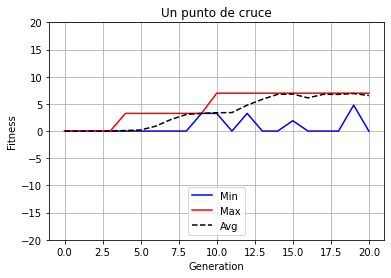

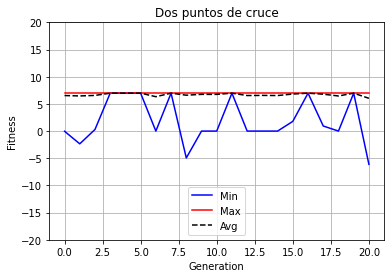

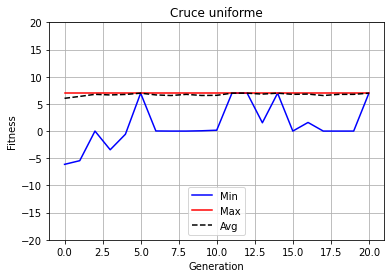

In [ ]:
# Se utilizan los registros log, log2 y log3 para graficar la adaptación 
# poblacional a lo largo de las distintas generaciones, a través del máximo 
# (Max), mínimo (Min) y valor medio (Avg).
plot_evolucion(log, 'Un punto de cruce')
plot_evolucion(log2, 'Dos puntos de cruce')
plot_evolucion(log3, 'Cruce uniforme')

En las gráficas, se observa que utilizando solo un punto de cruce, el algoritmo tarda más en converger a la solución óptima que en los otros métodos empleados.
La convergencia, se produce cuando la media de adaptación poblacional y el máximo (solución más óptima), adquieren valores similares ("se cruzan sus funciones en la gráfica"). No obstante esto se debe a que, debido a la aletoriedad hay un individuo con un fitness alto desde el principio (población inicial).

Esto, ocurre en las 3 gráficas y con valores similares. Sin embargo, en todos los casos se puede apreciar que no son necesarias 20 generaciones, ya que converge a la solución óptima antes. Si continuamos con el proceso, se puede llegar a crear un invididuo muy próximo a un máximo local, que quizá se adapte mejor que el resto de la población al problema, pero que se aleje bastante de la solución real, el máximo absoluto de la función objetivo. Si continuamos creando generaciones en este contexto, se corre este riesgo innecesariamente, además de aumentar el coste computacional.

Por otro lado, se puede apreciar con los mínimos poblacionales de adaptación, un comportamiento similar al que ocurre en la naturaleza, donde la aleatoriedad de los procesos de mutación y cruce pueden crear individuos bastante poco adaptados (exploración). 

Esto, hace que los mínimos de las gráficas no lleguen a converger claramente con la solución más óptima, porque es bastante posible que puedan aparecer este tipo de individuos poco adaptados. En contraste, también pueden aparacer otros individuos muy bien adaptados por este el proceso. Sin embargo, es difícil seguir encontrando individuos que claramente sean mejores que el resto de la población, solo ligeramente mejores, ya que el conjunto poblacional tiende a converger a la solución del problema.

Para este problema en concreto, no se pueden observar en general grandes diferencias entre utilizar un punto de cruce, dos puntos o cruce uniforme respecto al resultado obtenido. La única gran diferencia es el mayor tiempo de convergencia ya mencionado al utilizar un solo punto de cruce. 

Si nos fijamos en los resultados analíticos, observamos que la mejor media la tiene el algoritmo que emplea un cruce uniforme. Esto, quiere decir que la media de los mejores de cada una de las 20 iteraciones es superior al del resto de métodos.

No se debe confundir este valor promedio, con la media total de todas las poblaciones de las 20 iteraciones. Si se utilizase esta segunda media, en el caso de que uno de los tipos de cruce hiciese que el algoritmo convergiera antes a la solución pero fuese menos preciso, su media en este caso podría ser mayor que la de otro tipo de cruce más preciso pero que tardase más en converger. Por este motivo, se emplean solo las medias de los 20 mejores de cada tipo de cruce, al ser estos el resultado final, es decir, obviando los valores intermedios obtenidos.

Además, se utiliza la media de los mejores y no el mejor absoluto de cada tipo, porque así se reducen los efectos de la aleatoriedad presentes en el cruce y la mutación de individuos. Esta aleatoriedad, puede hacer que un método peor que otro pueda obtener un resultado que sea ligeramente mejor

En este caso en concreto, tanto la media de los mejores como el mejor absoluto indican que el algoritmo con cruce uniforme es el más óptimo, al tener los mayores valores en este problema de maximización.

#Conclusiones

En conclusión, podemos observar como en los tres puntos de cruce los mejores individuos son muy parecidos y cercanos al punto (0,0) de la función objetivo. Esto es lógico porque como se ve en el diagrama 3D que representa la función el pico ocurre cercano a este punto.

Al estar el pico tan cerca del punto (0,1.5), sería conveniente bajar el rango de exploración ya que podemos caer en no tener en cuenta otros picos proximos por falta de precisión decimal. También, podríamos aumentar el número de generaciones para ver si los resultados cambian o jugar con la probabilidad de mutación esperando que alguno de estos individuos se acerque mas pero sin llegar a generar superindividuos. 

Además, se podría investigar como varían los resultados con distintos valores de probabilidad de cruce o mutación para este problema en concreto. Incluso, se puede crear distintos modelos variando estos parámetros, y a su vez introducirlos en otro algoritmo genético que utilice los mejores de cada tipo como población inicial.

Por último, mencionar que parece que el cruce uniforme funciona mejor para este problema ya que la media de fitness del hof es mayor que el cruce con un punto y el cruce con dos puntos.

###Propuesta de mejora
Nosotros creemos que la forma más optima de alcanzar el máximo sería reducir el dominio y aumentar la precisión de los individuos. Esto se debe a que, como el gradiente de la función cerca de cero es muy alto, un cambio mínimo varía bastante el fitness del individuo. Vér codigo:

In [ ]:
ind1 = [0.00001, 1]
f1 = funcion_objetivo(ind1)
ind2 = [0.000001, 1.4]
f2 = funcion_objetivo(ind2)
print(f1)
print(f2)


(3.6886220126374343,)
(7.567884033663275,)
